In [256]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import numpy as np
#Frok from https://tianchi.aliyun.com/notebook/464582?spm=a2c22.12281897.0.0.32f123b7UBX8BT
# 手动指定 PingFang 字体的路径
font_path = '/System/Library/Fonts/PingFang.ttc'
# 设置字体为 PingFang
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = FontProperties(fname=font_path).get_name()
# 设置字体为 PingFang
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = FontProperties(fname=font_path).get_name()
mpl.rcParams["axes.unicode_minus"] = False

In [257]:
#加载数据
data_user=pd.read_csv('/Users/shendingyu/PycharmProjects/pythonProject4/data_small.csv')
pd.concat([data_user.head(5), data_user.tail(5)])

,user_id,sku_id,behavior_type,cate_id,time
0,124926433,20096172,1,10481,2014-12-04 00
1,105397406,85697534,1,3833,2014-12-04 00
2,105397406,318568409,1,9179,2014-12-04 00
3,105397406,398815064,1,675,2014-12-04 00
4,105397406,153751757,2,5388,2014-12-04 00
418970,141788152,6529319,1,5027,2014-12-16 23
418971,141788152,105750746,1,5027,2014-12-16 23
418972,7427667,11393704,1,1080,2014-12-16 23
418973,112976136,15008009,1,446,2014-12-16 23
418974,50372642,306820036,1,3064,2014-12-16 23


In [258]:
# 查看数据情况
print('数据大小为',len(data_user))
print('用户数量为：',len(set(data_user['user_id'])))
print('商品数量为：',len(set(data_user['sku_id'])))
print('商品品类为：',len(set(data_user['cate_id'])))

数据大小为 418975
用户数量为： 7784
商品数量为： 328439
商品品类为： 5933


# 数据处理

In [259]:
# 查看数据缺失情况
data_user.isnull().sum()

user_id          0
sku_id           0
behavior_type    0
cate_id          0
time             0
dtype: int64

In [260]:
#查看重复值个数
data_user.duplicated().sum()

0

可以看出数据良好，没有缺失值和重复值

In [261]:
# 分割天(date)和小时(hour)，方便后续做分析
data_user['date'] = data_user['time'].map(lambda x: x.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda x: x.split(' ')[1])
data_user.head()

,user_id,sku_id,behavior_type,cate_id,time,date,hour
0,124926433,20096172,1,10481,2014-12-04 00,2014-12-04,00
1,105397406,85697534,1,3833,2014-12-04 00,2014-12-04,00
2,105397406,318568409,1,9179,2014-12-04 00,2014-12-04,00
3,105397406,398815064,1,675,2014-12-04 00,2014-12-04,00
4,105397406,153751757,2,5388,2014-12-04 00,2014-12-04,00


In [262]:
# 查看字段类型：
data_user.dtypes

user_id           int64
sku_id            int64
behavior_type     int64
cate_id           int64
time             object
date             object
hour             object
dtype: object

In [263]:
#修改字段类型
data_user['user_id'] = data_user['user_id'].astype('object')
data_user['sku_id'] = data_user['sku_id'].astype('object')
data_user['cate_id'] = data_user['cate_id'].astype('object')
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['hour'] = data_user['hour'].astype('int64')

data_user.dtypes

user_id                  object
sku_id                   object
behavior_type             int64
cate_id                  object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

# 数据分析 & 可视化

## Part1. 流量分析
### 1. 基于天级别访问流量分析

In [264]:
# 计算PV: PageView , UV: UniqueView
# PV: select count(user_id) from data_user group by "date";
# UV: select count(distinct(user_id)) from data_user group by "date";
pv_daily = data_user.groupby('date')['user_id'].count()
# pv_daily.head()
pv_daily = pv_daily.reset_index() 
pv_daily = pv_daily.rename(columns={'user_id':'pv_daily'})
pv_daily

,date,pv_daily
0,2014-12-04,30281
1,2014-12-05,27695
2,2014-12-06,29359
3,2014-12-07,30195
4,2014-12-08,29040
5,2014-12-09,29877
6,2014-12-10,31623
7,2014-12-11,36817
8,2014-12-12,52205
9,2014-12-13,30809


In [265]:
#按日期看不太明显，我们可以对这组数据排序
pv_daily2=pv_daily.sort_values(by='pv_daily',ascending=False,ignore_index=True)
pv_daily2

,date,pv_daily
0,2014-12-12,52205
1,2014-12-11,36817
2,2014-12-10,31623
3,2014-12-13,30809
4,2014-12-14,30643
5,2014-12-15,30391
6,2014-12-04,30281
7,2014-12-07,30195
8,2014-12-16,30040
9,2014-12-09,29877


排过序后，我们可以清晰的看到在数据集给的一个月中，12月12日访问量最多，因为双十二促销活动

In [266]:
# 计算UV
uv_daily = data_user.groupby('date')['user_id'].apply(lambda x: len(x.unique()))
uv_daily = uv_daily.reset_index()
uv_daily = uv_daily.rename(columns = {'user_id':'uv_daily'})
uv_daily

,date,uv_daily
0,2014-12-04,4252
1,2014-12-05,4091
2,2014-12-06,4160
3,2014-12-07,4222
4,2014-12-08,4267
5,2014-12-09,4258
6,2014-12-10,4340
7,2014-12-11,4682
8,2014-12-12,5431
9,2014-12-13,4409


In [267]:
#同样地，对UV进行排序
uv_daily2=uv_daily.sort_values(by='uv_daily',ascending=False,ignore_index=True)
uv_daily2

,date,uv_daily
0,2014-12-12,5431
1,2014-12-11,4682
2,2014-12-13,4409
3,2014-12-15,4386
4,2014-12-16,4378
5,2014-12-10,4340
6,2014-12-14,4319
7,2014-12-08,4267
8,2014-12-09,4258
9,2014-12-04,4252


Text(0.5, 1.0, 'uv_daily')

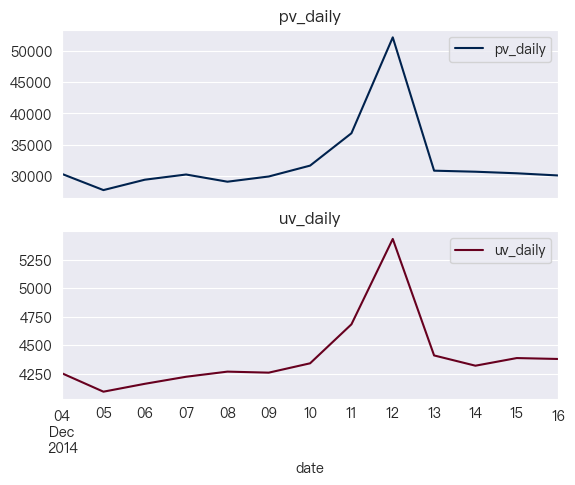

In [268]:
#可视化结果
fig,axes=plt.subplots(nrows=2,ncols=1,sharex=True)#共享x轴
pv_daily.plot(x='date',y='pv_daily',ax=axes[0],colormap='cividis')
uv_daily.plot(x='date',y='uv_daily',ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这正是著名的双十二大促节的用户集中消费导致的变化。
通过简单的数据分析和可视化工具，这是我们从数据中观察到了第一个结论。

In [269]:
#总访问量
pv=data_user['user_id'].count() #6213379
print("总访问量为：{}".format(pv))
#总访客量
uv=data_user['user_id'].unique().size
print("总独立访问量（访客量）为：{}".format(uv))
#人均访问量
per_pv=pv/uv
print("人均访问量为：{:.2f}".format(per_pv))
#日均访问量
day_pv=pv/31  #样本中共有31天
print("日均访问量为：{:.2f}".format(day_pv))


总访问量为：418975
总独立访问量（访客量）为：7784
人均访问量为：53.83
日均访问量为：13515.32


### 2. 基于小时级别访问流量分析

上面的对不同访问量进行分析，其分析的时间跨度是每天。另外从我们的直觉可以知道，用户在一天当中的使用也是有一定规律的。为了探索这个规律，我们将按照每小时统计用户的访问量和独立访问量。同pv_daily, uv_daily分析，我们完成如下代码：

In [270]:
# 计算每小时的PV
pv_hour = data_user.groupby('hour')['user_id'].count()
pv_hour = pv_hour.reset_index()
pv_hour = pv_hour.rename(columns={'user_id':'pv_hour'})
pv_hour

,hour,pv_hour
0,0,19253
1,1,10033
2,2,5313
3,3,3350
4,4,2553
5,5,3218
6,6,5329
7,7,9762
8,8,13713
9,9,17051


In [271]:
# 计算每小时UV
uv_hour = data_user.groupby('hour')['user_id'].apply(lambda x: len(x.unique()))
uv_hour = uv_hour.reset_index()
uv_hour = uv_hour.rename(columns={'user_id':'uv_hour'})
uv_hour

,hour,uv_hour
0,0,2752
1,1,1572
2,2,949
3,3,673
4,4,556
5,5,675
6,6,1223
7,7,2240
8,8,3009
9,9,3521


Text(0.5, 1.0, 'uv_hour')

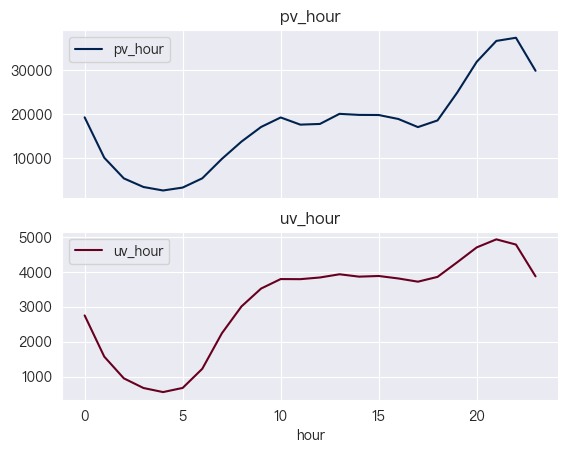

In [272]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

从“日PV/UV”趋势看，双十二当天的总体流量会出现明显的峰值。那么双十二当天基于小时的用户访问数据会有变化吗？我们来写代码分析：

In [273]:
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']
data_user_1212

,user_id,sku_id,behavior_type,cate_id,time,date,hour
244887,100509623,54858622,1,3064,2014-12-12 00,2014-12-12,0
244888,103802946,61629489,1,12141,2014-12-12 00,2014-12-12,0
244889,100509623,54858622,3,3064,2014-12-12 00,2014-12-12,0
244890,100684618,21959933,1,5623,2014-12-12 00,2014-12-12,0
244891,100684618,86254835,1,5623,2014-12-12 00,2014-12-12,0
...,...,...,...,...,...,...,...
297087,75547524,251563318,1,4007,2014-12-12 23,2014-12-12,23
297088,75547524,120337902,1,5399,2014-12-12 23,2014-12-12,23
297089,75547524,223862286,1,7213,2014-12-12 23,2014-12-12,23
297090,75547524,368705014,1,12921,2014-12-12 23,2014-12-12,23


In [274]:
data_user_1212.dtypes

user_id                  object
sku_id                   object
behavior_type             int64
cate_id                  object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

In [275]:
# 计算每小时的PV
pv_hour_1212 = data_user_1212.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'1212_pv_hour'})
uv_hour_1212 = data_user_1212.groupby('hour')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'1212_uv_hour'})
#pv_hour_1212
uv_hour_1212

,hour,1212_uv_hour
0,0,942
1,1,472
2,2,243
3,3,132
4,4,110
5,5,151
6,6,318
7,7,648
8,8,804
9,9,898


Text(0.5, 1.0, 'pv_hour_1212')

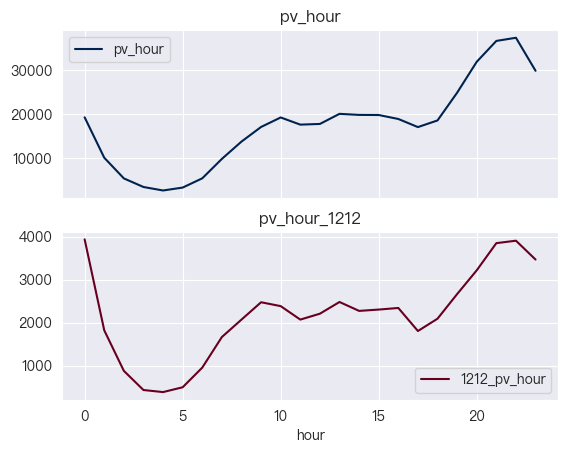

In [276]:
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
pv_hour_1212.plot(x='hour', y='1212_pv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('pv_hour_1212')

Text(0.5, 1.0, 'uv_hour_1212')

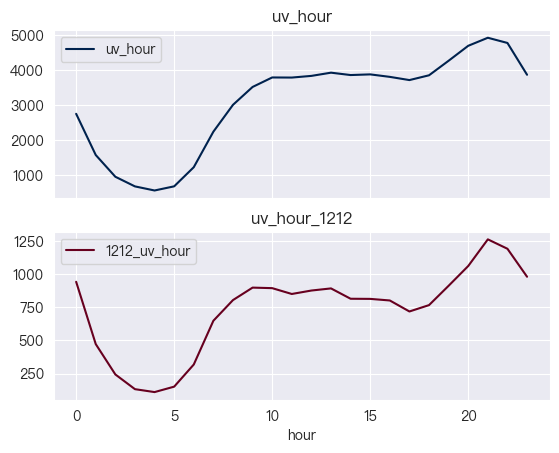

In [277]:
# 可视化 UV
fig, axes = plt.subplots(2,1,sharex=True)
uv_hour.plot(x='hour',y='uv_hour',ax=axes[0],colormap='cividis')
uv_hour_1212.plot(x='hour', y='1212_uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('uv_hour')
axes[1].set_title('uv_hour_1212')

可以看到，双十二当天，PV变化趋与一个月内的PV变化趋势基本一致。UV变化趋势稍有不同，可以看到双十二当天在晚上8点之后UV出现了小高峰，表明了大促当天用户的消费意愿比较强烈。

### 3. 不同用户行为流量分析

In [278]:
# 基于 behavior_type & hour 分组
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
pv_behavior = data_user.groupby(['behavior_type','hour'])['user_id'].count()
pv_behavior = pv_behavior.reset_index()
pv_behavior = pv_behavior.rename(columns={'user_id':'pv_behavior'})
pv_behavior

,behavior_type,hour,pv_behavior
0,1,0,17929
1,1,1,9444
2,1,2,5001
3,1,3,3170
4,1,4,2402
...,...,...,...
91,4,19,215
92,4,20,281
93,4,21,346
94,4,22,360


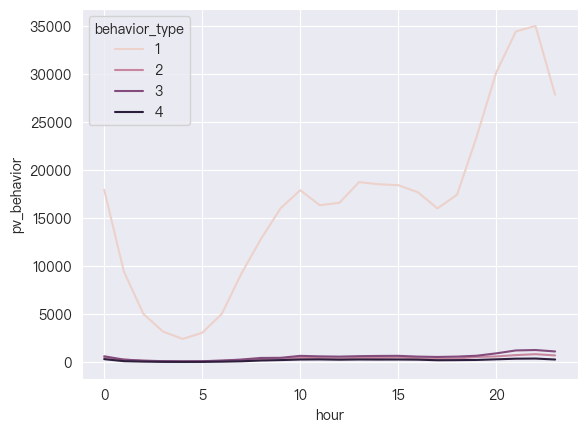

In [279]:
# 可视化
# sns: serborn
ax = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior)

因为behavior_type为1（浏览行为）的占比非常大，导致上图其它几类behavior的趋势不太明显，我们去掉behavior_type为1的数据后再来看看：

<Axes: xlabel='hour', ylabel='pv_behavior'>

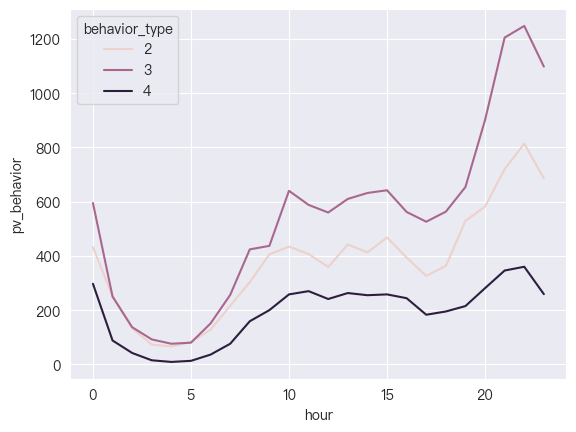

In [280]:
sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior[pv_behavior.behavior_type!=1])

可以看出4种行为按照小时的变化趋势基本一致，都是在晚上7点之后有明显增长，凌晨2-6点是低峰，符合常识。

对双十二当天对用户行为进行分析：

In [281]:
pv_behavior_1212 = data_user_1212.groupby(['behavior_type','hour'])['user_id'].count()
pv_behavior_1212 = pv_behavior_1212.reset_index()
pv_behavior_1212 = pv_behavior_1212.rename(columns={'user_id':'pv_behavior_1212'})
pv_behavior_1212

,behavior_type,hour,pv_behavior_1212
0,1,0,3510
1,1,1,1664
2,1,2,810
3,1,3,408
4,1,4,362
...,...,...,...
91,4,19,40
92,4,20,45
93,4,21,77
94,4,22,86


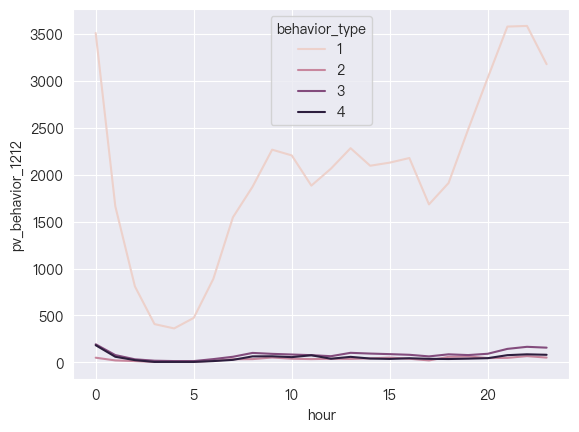

In [282]:
# 可视化
# sns: serborn
ax = sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212)

可以看出，双十二当天，凌晨点击量非常大，因为许多用户在活动刚开始时就来浏览和购物。这可能是由于限时抢购、优惠券等促销活动吸引了大量用户。

因为behavior_type为1（浏览行为）的占比非常大，导致上图其它几类behavior的趋势不太明显，我们去掉behavior_type为1的数据后再来看看：

<Axes: xlabel='hour', ylabel='pv_behavior_1212'>

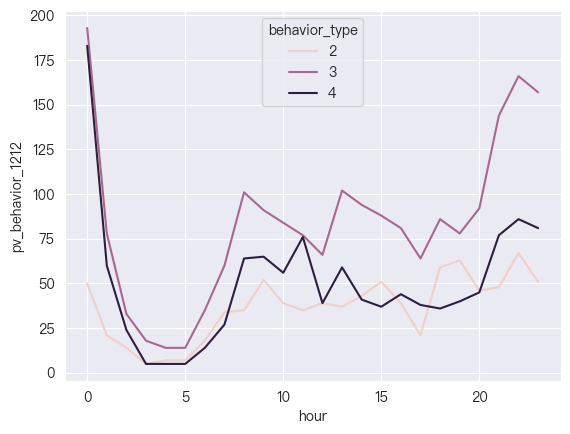

In [283]:
#点击、收藏、加购物车、支付 --1 2 3 4
sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212[pv_behavior_1212.behavior_type!=1])

在双十二当天，加购物车和支付这两种行为按照小时的变化趋势基本一致，而收藏这种行为按小时的的变化趋势与其他两种有点差异；双十二当天凌晨，用户支付量和加入购物车的数量比较大，可能是因为双十二当天很多电商平台会推出限时抢购和优惠促销等活动，而凌晨是一些抢购活动的开始时间，用户在这个时候会将心仪的商品加入购物车，并快速支付以确保能够抢到心仪的商品；收藏量比较少是比较正常的，因为双十二促销活动，用户更倾向于快速购买而不是将商品收藏。

对比分析一个月中每天某个时刻四种行为与双十二当天某个时刻四种行为的区别：双十二是否使用户某个行为增多？

Text(0.5, 1.0, 'pv_behavior_1212')

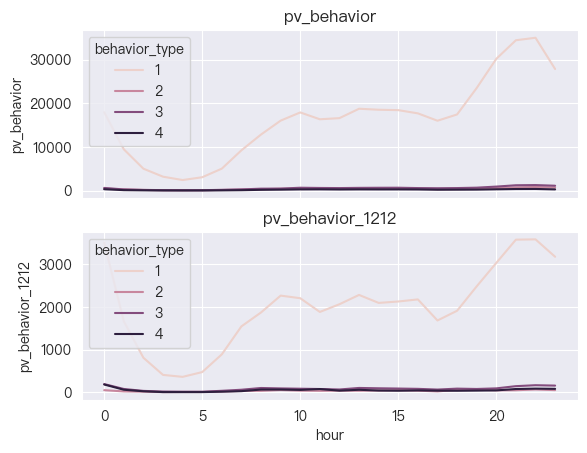

In [284]:
fig, axes = plt.subplots(2,1,sharex=True)
ax1 = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior,ax=axes[0])
ax2 = sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212,ax=axes[1])
axes[0].set_title('pv_behavior')
axes[1].set_title('pv_behavior_1212')

可以看出来，双十二促销活动使得双十二凌晨淘宝点击量比一个月中凌晨平均点击量高了很多。

Text(0.5, 1.0, 'pv_behavior_1212')

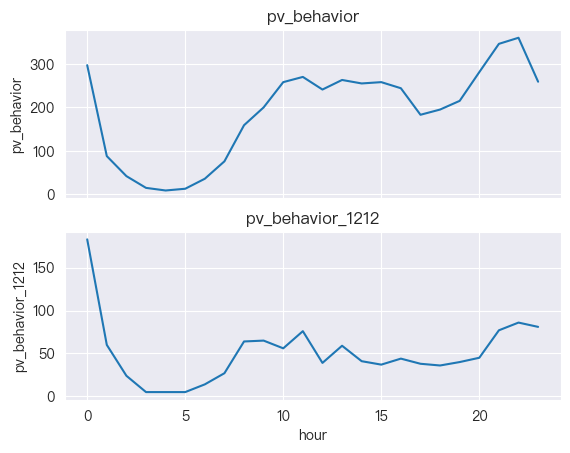

In [285]:
fig, axes = plt.subplots(2,1,sharex=True)
ax3 = sns.lineplot(x='hour',y='pv_behavior',data=pv_behavior[pv_behavior.behavior_type==4],ax=axes[0])
ax4 = sns.lineplot(x='hour',y='pv_behavior_1212',data=pv_behavior_1212[pv_behavior_1212.behavior_type==4],ax=axes[1])
axes[0].set_title('pv_behavior')
axes[1].set_title('pv_behavior_1212')

虽然双十二当天凌晨收藏量相比其他三种行为较少，但是双十二促销活动吸引了大量用户，使得凌晨收藏量比一个月平均每天凌晨收藏量高。

由此说明，电商平台应该多推出这种促销活动，可以吸引用户，促进商品销量。

我们在充分了解用户分时的数据趋势后，可以针对性的进行营销活动，如推送优惠劵等，大家也可以留意下日常使用电商类App的推送通知的推送时间，一般都是在用户高峰期来做推送，可进一步促进转化率。

## Part2. 转化率分析

我们来分析“浏览-收藏/加购-购买”链路的转化漏斗模型，可以帮助我们更好的了解各个环节的转化链路：

In [286]:
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
behavior_type = data_user.groupby(['behavior_type'])['user_id'].count()
behavior_type

behavior_type
1    392457
2      9028
3     12927
4      4563
Name: user_id, dtype: int64

可以看到，用户浏览（behavior_type=1）的基数是最大的，因为加购和收藏没有必然联系，因此我们把这两类合并在一起做分析：

In [287]:
click_num, fav_num, add_num, pay_num =  behavior_type[1], behavior_type[2], behavior_type[3], behavior_type[4]

fav_add_num = fav_num + add_num 
print('点击 到 加购/收藏转化率：', 100 * fav_add_num / click_num)
print('点击 到 购买转化率: ', 100 * pay_num / click_num)
print('加购/收藏 到 购买转化率: ', 100 * pay_num / fav_add_num)
print('点击 到 收藏的转化率：',100 * fav_num /click_num)

点击 到 加购/收藏转化率： 5.5942434457787735
点击 到 购买转化率:  1.1626751465765677
加购/收藏 到 购买转化率:  20.783420633113185
点击 到 收藏的转化率： 2.300379404622672


可以观察到，从浏览到加购/收藏的转化率大约5.6%；"加购/收藏"后到购买转化率大约为20%，这个比例还是还是非常高的，说明用户感兴趣的商品更容易成单。
两者相乘，我们能粗略估出从浏览到购买的转化率约为1.2%左右。

In [288]:
#画漏斗图
import plotly.graph_objects as go

# 数据
data = [392457, 9028+12927, 4563]
phase = ['点击', '收藏/加购物车', '支付']

# 创建漏斗图
fig = go.Figure(go.Funnel(
    y = phase,
    x = data,
    textinfo = "value+percent initial"))

# 显示图表
fig.show()

可以看出，点击量到购买量的转化率大约为1%

### 1. 复购情况分析
因此复购率的计算方式为：复购率 = 复购用户数量 / 有购买行为的用户数量。基于这个公式，我们先计算用户在数据集中的购买频次：

In [289]:
# 计算用户购买频次
data_user_pay = data_user[data_user.behavior_type==4]
# 基于date去重，得到的结果即为购物分布的天数：
data_user_pay = data_user_pay.groupby('user_id')['date'].apply(lambda x: len(x.unique()))
data_user_pay

user_id
7591         2
12645        1
79824        1
88930        1
100539       2
            ..
142168798    2
142227202    3
142244794    1
142368840    1
142430177    1
Name: date, Length: 2637, dtype: int64

In [290]:
# 计算复购率：
repeat_buy_ratio = data_user_pay[data_user_pay > 1].count() / data_user_pay.count()
repeat_buy_ratio

0.2950322335987865

这批抽样数据在1个月内的复购率仅为30%，说明用户忠诚度略显不足

### 2. 复购周期分析

除了以上对复购频次的统计，还需要对复购意向做进一步的探究，想要知道用户多久复购一次。这个数据有助于产品宣传采取策略，增加用户的复购意向，最终转化为实际收益。

In [291]:
data_user['action'] = 1 # 对每一行的行为记为1次，通过对行为次数的相加，从而计算频次
data_user_buy = data_user[data_user.behavior_type == 4]
data_user_buy = data_user_buy.groupby(['user_id','date'])['action'].count()
data_user_buy = data_user_buy.reset_index()
data_user_buy.head(30)

,user_id,date,action
0,7591,2014-12-04,1
1,7591,2014-12-06,1
2,12645,2014-12-14,1
3,79824,2014-12-05,1
4,88930,2014-12-12,1
5,100539,2014-12-07,1
6,100539,2014-12-16,1
7,120873,2014-12-15,1
8,151617,2014-12-08,1
9,151617,2014-12-12,1


In [292]:
# 对日期排序（按照先后顺序），给予pandas的date函数计算前后两次购物相差的天数，dropna去掉了每个用户在数据集周期内第一次购买日期的记录：
data_user_buy_date_diff = data_user_buy.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1).dropna())
data_user_buy_date_diff.head(30)

user_id    
7591     1    2 days
100539   6    9 days
151617   9    4 days
475826   15   8 days
         16   4 days
611920   22   3 days
914729   27   4 days
1030408  31   5 days
1137672  34   2 days
         35   3 days
1259845  40   7 days
1364464  43   9 days
1725399  49   2 days
1857066  54   2 days
1926899  56   4 days
         57   2 days
         58   1 days
         59   4 days
2172795  64   1 days
2302002  68   2 days
         69   6 days
2319819  71   1 days
2489487  75   1 days
2686606  77   8 days
2695854  79   6 days
2742560  81   1 days
2935703  87   1 days
2952532  89   2 days
         90   6 days
3166978  97   5 days
Name: date, dtype: timedelta64[ns]

这里稍微解释下计算的结果，第1列为索引列，即为user_id列； 第二列为该条记录在原始dataframe表中的索引位置，即data_user_buy的默认索引，第三列为同一用户相邻两个购买日期的求差结果

Text(0, 0.5, 'count')

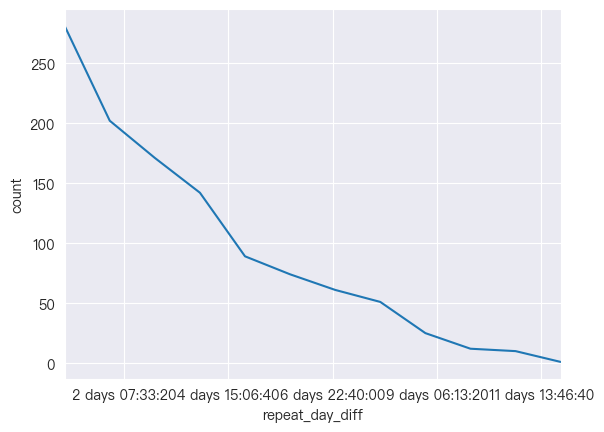

In [293]:
#可视化结果
data_user_buy_date_diff.value_counts().plot(kind='line')
plt.xlabel('repeat_day_diff')
plt.ylabel('count')

In [294]:
#上图中的横坐标有HH:MM:SS，我们只保留到days再重新绘制一下：
data_user_buy_date_diff = data_user_buy_date_diff.apply(lambda x:x.days)
data_user_buy_date_diff

user_id        
7591       1        2
100539     6        9
151617     9        4
475826     15       8
           16       4
                   ..
142120051  3744     8
           3745     2
142168798  3749    11
142227202  3751     6
           3752     1
Name: date, Length: 1119, dtype: int64

Text(0, 0.5, 'count')

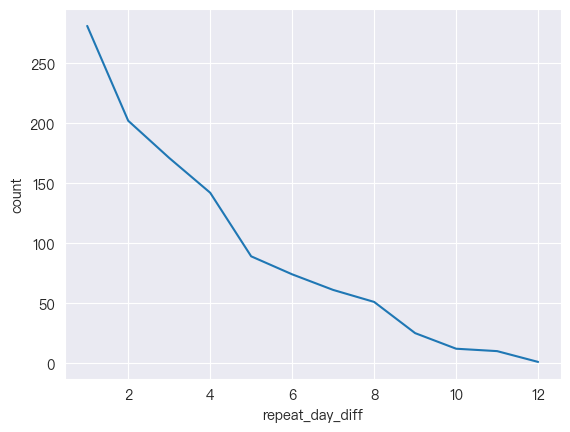

In [295]:
data_user_buy_date_diff.value_counts().plot(kind='line')

plt.xlabel('repeat_day_diff')
plt.ylabel('count')

可以看出，用户复购行为在五天内下降快数量多，五天后下降慢数量少。

# RFM模型

RFM模型是通过一个客户的近期购买行为、购买的总体频率以及花了多少钱3个维度来描述该客户价值状况的客户分类模型，这3个维度分别表示为：

最近一次消费距离现在的时间 (Recency)：这个值越小对我们来说价值越大</br>
某段时间内消费频率次数 (Frequency)：这个值越大越好</br>
某段时间内消费金额 (Monetary)：这个值越大越好</br>
根据这三个维度将用户分为了8类，我们需要重点关注一些有价值的客户

由于本数据集中没有给出消费金额，所以我们只给R和F打分，对客户进行分类

In [296]:
#最近一次消费距离现在的时间，我们计算用户最后一次消费的日期距离本样本中最后一天的日期即可，即2014-12-18
rfm=data_user[data_user['behavior_type']==4]
rfm=rfm.groupby('user_id')['date'].max()#最后一次的消费日期
rfm=rfm.reset_index()
rfm['internal']='2014-12-18'
rfm['internal']=pd.to_datetime(rfm['internal'])
rfm.dtypes
rfm['internal']=rfm['internal']-rfm['date'] #有单位不好计算，所以只取days,不要单位
rfm['internal']=rfm['internal'].dt.days
rfm

,user_id,date,internal
0,7591,2014-12-06,12
1,12645,2014-12-14,4
2,79824,2014-12-05,13
3,88930,2014-12-12,6
4,100539,2014-12-16,2
...,...,...,...
2632,142168798,2014-12-16,2
2633,142227202,2014-12-12,6
2634,142244794,2014-12-16,2
2635,142368840,2014-12-05,13


In [297]:
#最近一段时间的消费频次,前面已经计算过
rfm=pd.merge(rfm,data_user_pay,how='inner',on='user_id')
rfm.rename(columns={'date_y':'frequency'},inplace=True)
rfm

,user_id,date_x,internal,frequency
0,7591,2014-12-06,12,2
1,12645,2014-12-14,4,1
2,79824,2014-12-05,13,1
3,88930,2014-12-12,6,1
4,100539,2014-12-16,2,2
...,...,...,...,...
2632,142168798,2014-12-16,2,2
2633,142227202,2014-12-12,6,3
2634,142244794,2014-12-16,2,1
2635,142368840,2014-12-05,13,1


In [298]:
r_avg=rfm['internal'].mean()
f_avg=rfm['frequency'].mean()
print(r_avg)
print(f_avg)

6.75616230565036
1.4243458475540387


In [299]:
#打分方式有很多种，这里我们选择比较简单的一种
#为每个用户打分,对于R，小于平均消费时间间隔的赋值为high，大于的赋值为low
#为每个用户打分,对于F，大于平均消费频次的赋值为high，小于的赋值为low
#本样本中没有给出金额数据，所以我们把客户分为4种
for i in range(len(rfm)):
    if(rfm.at[i,'internal']<r_avg):
        rfm.at[i,'R']='high'
    else:
        rfm.at[i,'R']='low'
    if(rfm.at[i,'frequency']>f_avg):
        rfm.at[i,'F']='high'
    else:
        rfm.at[i,'F']='low'
rfm

,user_id,date_x,internal,frequency,R,F
0,7591,2014-12-06,12,2,low,high
1,12645,2014-12-14,4,1,high,low
2,79824,2014-12-05,13,1,low,low
3,88930,2014-12-12,6,1,high,low
4,100539,2014-12-16,2,2,high,high
...,...,...,...,...,...,...
2632,142168798,2014-12-16,2,2,high,high
2633,142227202,2014-12-12,6,3,high,high
2634,142244794,2014-12-16,2,1,high,low
2635,142368840,2014-12-05,13,1,low,low


In [300]:
for i in range(len(rfm)):
    if((rfm.at[i,'R']=='high') and (rfm.at[i,'F']=='high')):
        rfm.at[i,'重要价值']='重要价值用户'
    elif((rfm.at[i,'R']=='high') and (rfm.at[i,'F']=='low')):
        rfm.at[i,'重要价值']='重要发展用户'
    elif((rfm.at[i,'R']=='low') and (rfm.at[i,'F']=='high')):
        rfm.at[i,'重要价值']='重要保持用户'
    elif((rfm.at[i,'R']=='low') and (rfm.at[i,'F']=='low')):
        rfm.at[i,'重要价值']='重要挽留用户'
rfm

,user_id,date_x,internal,frequency,R,F,重要价值
0,7591,2014-12-06,12,2,low,high,重要保持用户
1,12645,2014-12-14,4,1,high,low,重要发展用户
2,79824,2014-12-05,13,1,low,low,重要挽留用户
3,88930,2014-12-12,6,1,high,low,重要发展用户
4,100539,2014-12-16,2,2,high,high,重要价值用户
...,...,...,...,...,...,...,...
2632,142168798,2014-12-16,2,2,high,high,重要价值用户
2633,142227202,2014-12-12,6,3,high,high,重要价值用户
2634,142244794,2014-12-16,2,1,high,low,重要发展用户
2635,142368840,2014-12-05,13,1,low,low,重要挽留用户


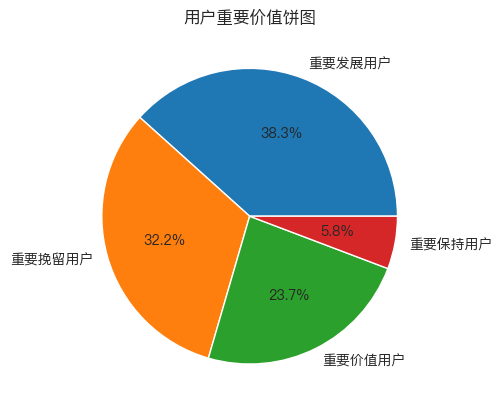

In [301]:
#可视化
plt.figure()
#plt.pie([rfm[rfm['重要价值']=='重要价值用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要发展用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要保持用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要挽留用户']['重要价值'].count()],
#        labels=['重要价值用户','重要发展用户','重要保持用户','重要挽留用户'],autopct='%1.1f%%')
counts = rfm['重要价值'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('用户重要价值饼图')
plt.show()

用户忠诚度较低，有将近三分之一的用户是重要挽留客户

可以看出，重要价值用户是最多的，即购买时间间隔短，并且消费频次高的人数最多，这部分人群需要重点关注，可以给他们发放专属特别优惠，提升用户满意度；</br>
重要挽留用户，即消费时间间隔长，消费频次低的客户，这部分客户即将流失，要想办法挽留用户，可以给他们推送打折消息、优惠活动等等</br>
重要发展用户，需要提高他们的消费频次，可以在每次购物之后提供好评返现、限时优惠券等等，刺激他们下一次消费</br>
重要保持用户，消费频次高但是最近无消费，可以向这部分用户推送打折消息，发放优惠券等

可以看出，本次抽样中，重要挽留客户较多，需要重点关注